# Анализ поведения пользователей мобильного приложения

**Цель проекта:** Нужно разобраться, как ведут себя пользователи мобильного приложения по продаже продуктов питания и провести анализ результатов A/A/B-эксперимента. 

**Задачи проекта:**

    - изучить общую информацию и подготовить данные к анализу;
    - провести общий анализ данных;
    - изучить воронку событий;
    - провести анализ результатов эксперимента;
    - вывод

**Описание данных**

    Каждая запись в логе — это действие пользователя, или событие. 
    EventName — название события;
    DeviceIDHash — уникальный идентификатор пользователя;
    EventTimestamp — время события;
    ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.


Шаг 1. Откроем файл с данными и изучим общую информацию

In [253]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import math as mth
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sb
from scipy import stats as st
import plotly.express as px

In [254]:
# загружаем данные о событиях из CSV-файла в переменную 
try:
    df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    df = pd.read_csv('logs_exp.csv', sep='\t')

In [255]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [256]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Перед нами данные о событиях пользователей приложения с указанием наименования событий, идентификатора пользователя, даты и времени события, а также номера группы.

Шаг 2. Подготовка данных

In [257]:
# заменим наименования столбцов
df.rename(columns = {'EventName':'event_name', 'DeviceIDHash': 'user_id', 'EventTimestamp': 'event_timestamp', 'ExpId': 'group'}, inplace = True )

In [258]:
# проверим наличие пропущенных значений
df.isna().sum()

event_name         0
user_id            0
event_timestamp    0
group              0
dtype: int64

In [259]:
# проверим наличие явных дубликатов
print('Количество дубликатов в таблице:', df.duplicated().sum())

Количество дубликатов в таблице: 413


In [260]:
# посчитаем долю дубликатов в процентах
display(round(df.duplicated().sum()*100/len(df),2))

0.17

In [261]:
# удаляем дубликаты
df=df.drop_duplicates().reset_index(drop=True)

In [262]:
# приведем значения столбца event_timestamp к типу даты
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], unit='s')

In [263]:
# добавим отдельный столбец дат
df['date'] = pd.to_datetime(df['event_timestamp'].dt.date)


In [264]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   user_id          243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   group            243713 non-null  int64         
 4   date             243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


In [265]:
df.head()

,event_name,user_id,event_timestamp,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [266]:
# посмотрим уникальные названия событий
df['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

Неявные дубликаты в датафрейме отсутствуют.

In [267]:
# проверим наличие пользователей, которые вошли в более, чем одну группу исследования
df.groupby('user_id').agg({'group': 'nunique'}).query('group > 1').count()


group    0
dtype: int64

In [268]:
# посмотрим, за какой период предоставлены данные
print('Данные о событиях за период с ',df['event_timestamp'].min(), ' по ', df['event_timestamp'].max())

Данные о событиях за период с  2019-07-25 04:43:36  по  2019-08-07 21:15:17


В ходе предобработки данных изменила наименования столбцов. Проведена проверка на наличие пропущенных значений: пропусков в датафрейме нет. Были выявлены и удалены 413 явных дубликатов. Изменила тип данных в столбце event_timestamp и добавила новый столбец, содержащий только дату события. Проверила пересечение групп: пользователей, вошедших в более чем одну группу, не обнаружено.
Итак, данные о событиях за период с 25.07.2019 по 07.08.2019 готовы к анализу.


Шаг 3. Общий анализ данных

In [269]:
print('Общее количество событий в логе:', len(df))

Общее количество событий в логе: 243713


In [270]:
print('Количество уникальных пользователей в логе:', df['user_id'].nunique())

Количество уникальных пользователей в логе: 7551


Для расчета средего количества событий на одного пользователя посчитаем количество событий для каждого user_id

In [271]:
cnt_events = df.groupby('user_id')['event_timestamp'].count().reset_index()
cnt_events.head()

,user_id,event_timestamp
0,6888746892508752,1
1,6909561520679493,5
2,6922444491712477,47
3,7435777799948366,6
4,7702139951469979,137


Уже по первым 5 строкам видно, что распределение количества событий не нормально. Поэтому рассчитаем медиану.

In [272]:
print('Среднее количество событий на одного пользователя:', cnt_events['event_timestamp'].median())

Среднее количество событий на одного пользователя: 20.0


Теперь посмотрим, как меняется количество данных: построим столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп. 

In [273]:
# сгруппируем данные по группам и датам совершения событий 
df_pivot = pd.pivot_table(df, index='date', columns='group', values='event_name', aggfunc='count').sort_values(by='date', ascending=True)
df_pivot.head()


group,246,247,248
date,,,
2019-07-25,4,1,4
2019-07-26,14,8,9
2019-07-27,24,23,8
2019-07-28,33,36,36
2019-07-29,55,58,71


<Figure size 3000x500 with 0 Axes>

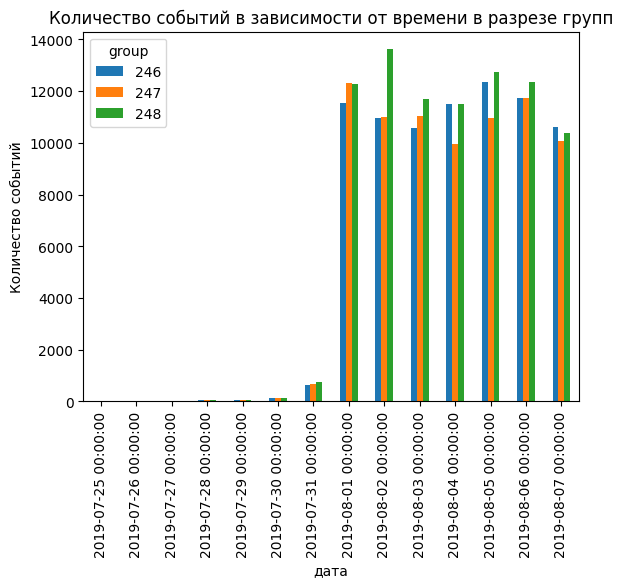

In [308]:
# построим столбчатую диаграмму
plt.figure(figsize=(30, 5))
df_pivot.plot.bar()

plt.title('Количество событий в зависимости от времени в разрезе групп')
plt.ylabel('Количество событий')
plt.xlabel('дата')
plt.show()

На диаграмме видно, что количество событий по 31.07.2019 очень мало. Это означает, что мы располагаем полными данными о событиях за период с 01.08.2019 по 07.08.2019.


Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные».

In [275]:
df_old = df[df['date'] <'2019-08-01']
df_old.head()

,event_name,user_id,event_timestamp,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [276]:
df_old.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2826 entries, 0 to 2825
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   event_name       2826 non-null   object        
 1   user_id          2826 non-null   int64         
 2   event_timestamp  2826 non-null   datetime64[ns]
 3   group            2826 non-null   int64         
 4   date             2826 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 132.5+ KB


In [277]:
# объявим переменную, содержащую список пользователей в "старых" данных и выведем их количество
old_users = df_old['user_id'].unique()
print('количество уникальных пользователей в "старых" данных:', len(old_users))

количество уникальных пользователей в "старых" данных: 1451


In [278]:
# отбросим "старые" данные
df_new = df.query('user_id not in @old_users').reset_index()

Много ли событий и пользователей вы потеряли, отбросив старые данные?

In [279]:
print('количество событий, потерянных в результате отброса старых данных:',len(df) - len(df_new))

количество событий, потерянных в результате отброса старых данных: 60057


Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

In [280]:
df_group = df_new.groupby('group')['user_id'].nunique().reset_index()
df_group

,group,user_id
0,246,2030
1,247,2036
2,248,2034


In [281]:
# относительное различие количества пользователей между группами 246 и 248
print('относительное различие количества пользователей между группами 246 и 248:',round((1-df_group.loc[0,'user_id']/df_group.loc[2,'user_id'])*100,2),'%')

относительное различие количества пользователей между группами 246 и 248: 0.2 %


In [282]:
# относительное различие количества пользователей между группами 247 и 248
print('относительное различие количества пользователей между группами 247 и 248:',round((1-df_group.loc[1,'user_id']/df_group.loc[2,'user_id'])*100,2),'%')

относительное различие количества пользователей между группами 247 и 248: -0.1 %


Вывод: В логе всего 243713 событий и 7551 уникальных пользователей. В среднем на пользователя приходится 20 событий.
Мы располагаем данными о событиях за период с 25.07.2019 по 07.08.2019. Однако, изучив столбчатую диаграмму "Количество событий в зависимости от времени в разрезе групп", можно сказать, что мы располагаем полными данными о событиях за период с 01.08.2019 по 07.08.2019.
Так как технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого, это может «перекашивать данные». Отбросили "старые" данные по 1451 уникальному пользователю. При этом мы теряем 60057 событий. 
Но при этом группы теста распределились равномерно, относительное различие количества пользователей между группами 246 и 248 и между группами 247 и 248 незначительно: 0,2% и -0,1% соответственно.

Шаг 4. Изучим воронку событий


In [283]:
# Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте
df['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

Просмотр главной страницы - самое частовстречающееся событие, самое непопулярное - просмотр обучающего материала

In [284]:
# Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей.
df_funnel = df.groupby('event_name')['user_id'].nunique().reset_index().sort_values('user_id', ascending=False)
df_funnel

,event_name,user_id
1,MainScreenAppear,7439
2,OffersScreenAppear,4613
0,CartScreenAppear,3749
3,PaymentScreenSuccessful,3547
4,Tutorial,847


In [285]:
# построим воронку событий
fig = px.funnel(df_funnel, x=list(df_funnel['user_id']), y=list(df_funnel['event_name']))
fig.show()

Посчитайте долю пользователей, которые хоть раз совершали событие.

In [286]:
# добавим столбец с общим количеством пользователей
df_funnel['total'] = df['user_id'].nunique()

In [287]:
# добавим столбец с долей пользователей, которые хоть раз совершали событие
df_funnel['part'] = round(df_funnel['user_id']/df_funnel['total'],3)
df_funnel

,event_name,user_id,total,part
1,MainScreenAppear,7439,7551,0.985
2,OffersScreenAppear,4613,7551,0.611
0,CartScreenAppear,3749,7551,0.496
3,PaymentScreenSuccessful,3547,7551,0.470
4,Tutorial,847,7551,0.112


Можно предположить, что события выстраиваются в следующую цепочку событий: просмотр главной страницы, просмотр предложений, вход в корзину и оплата заказа. Событие Tutorial (просмотр инструкций) пользователь может совершить на любом шаге. И количество пользователей, совершивших данное действие, очень мало, всего 11% пользователей совершали данное событие.

Также следует отметить, что в нашем логе около 1,5% уникальных пользователей не заходили на главную страницу. Скорее всего, данное событие просто произошло ранее начала периода, за который у  нас имеются данные.

По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). 

In [288]:
print('доля пользователей, перешедших от просмотра главного экрана к экрану с предложениями:',\
      round(df_funnel.loc[2,'part']/df_funnel.loc[1,'part'],2))


доля пользователей, перешедших от просмотра главного экрана к экрану с предложениями: 0.62


In [289]:
print('доля пользователей, перешедших от просмотра предложений к просмотру корзины:',\
      round(df_funnel.loc[0,'part']/df_funnel.loc[2,'part'],2))

доля пользователей, перешедших от просмотра предложений к просмотру корзины: 0.81


In [290]:
print('доля пользователей, перешедших от просмотра корзины к совершению покупки:',\
      round(df_funnel.loc[3,'part']/df_funnel.loc[0,'part'],2))

доля пользователей, перешедших от просмотра корзины к совершению покупки: 0.95


Больше всего пользователей теряется на первом шаге. 62% пользователей переходят с главной страницы на страницу с предложениями.
Какая доля пользователей доходит от первого события до оплаты?

In [291]:
print('доля пользователей, которые доходят от просмотра главной страницы к совершению покупки:',\
      round(df_funnel.loc[3,'part']/df_funnel.loc[1,'part'],2))

доля пользователей, которые доходят от просмотра главной страницы к совершению покупки: 0.48


Вывод: Исходя из имеющихся данных, чаще всего пользователи совершают событие "MainScreenAppear" - 119101 случаев. Событие Tutorial случается редко, всего 1018 случаев. Предположим, что события выстраиваются в следующую цепочку событий: просмотр главной страницы, просмотр предложений, вход в корзину и оплата заказа. Событие Tutorial (просмотр инструкций) пользователь может совершить на любом шаге. И количество пользователей, совершивших данное действие, очень мало, всего 11% пользователей совершали данное событие.
Также следует отметить, что в нашем логе около 1,5% уникальных пользователей не заходили на главную страницу. Скорее всего, данное событие просто произошло ранее начала периода, за который у  нас имеются данные.
Доля пользователей, прошедших цепочку событий от главного экрана до покупки составила 48%.

Шаг 5. Анализ результатов эксперимента


In [292]:
df_group

,group,user_id
0,246,2030
1,247,2036
2,248,2034


Итак, мы имеем 3 группы теста. Количество пользователей в группах приблизительно одинаково, относительное различие количества пользователей между группами 246 и 248 и между группами 247 и 248 незначительно: 0,2% и -0,1% соответственно.

Так как событие Tutorial (просмотр инструкций) пользователь может совершить на любом шаге и количество пользователей, совершивших данное действие, очень мало, всего 11%, исключим данное событие из датафрейма.

In [293]:
df_new = df_new.query('event_name != "Tutorial"')

In [294]:
# Создадим функцию для определения статистической разницы между долями пользователей, совершивших заданное событие в группе 1 и в группе 2
alpha = .05 # критический уровень статистической значимости

list_events_name = df_new['event_name'].unique()#список событий

def z_test(df1, df2, event_name, alpha):
    alpha=alpha
    
    # общее количество пользователей в группах 1 и 2
    cnt_users1 = df1['user_id'].nunique()
    cnt_users2 = df2['user_id'].nunique()
    
    # количество пользователей, совершивших заданное событие в группах 1 и 2
    successes1 = df1[df1['event_name']==event_name]['user_id'].nunique()
    successes2 = df2[df2['event_name']==event_name]['user_id'].nunique()
    
    # пропорция успехов в первой группе:
    p1 = successes1/cnt_users1

    # пропорция успехов во второй группе:
    p2 = successes2/cnt_users2

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes1 + successes2) / (cnt_users1 + cnt_users2)

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/cnt_users1 + 1/cnt_users2))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('\n'+'\033[1m' + event_name + ':' + '\033[0m')
    print('p_value: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )

Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247. Проверим, есть ли статистическая разница между контрольными группами  246 и 247 
Сформулируем гипотезы.
Нулевая гипотеза: доли пользователей, совершивших заданное событие в группе 246 и в группе 247 равны
Альтернативная гипотеза: доли пользователей, совершивших заданное событие в группе 246 и в группе 247 не равны

In [295]:
df_246 = df_new[df_new['group'] == 246]


In [296]:
df_247 = df_new[df_new['group'] == 247]

In [297]:
for event_name in list_events_name:
    z_test(df_246, df_247, event_name, alpha)


MainScreenAppear:
p_value:  0.9914507535878616
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear:
p_value:  0.20011049342367326
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear:
p_value:  0.315434439952208
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful:
p_value:  0.14114877154345873
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


При заданном уровне статистической значимости у нас нет оснований считать группы 246 и 247 разными.


Проверим, есть ли статистическая разница между контрольной группой 246 и экспериментальной 248 
Сформулируем гипотезы.
Нулевая гипотеза: доли пользователей, совершивших заданное событие в группе 246 и в группе 248 равны
Альтернативная гипотеза: доли пользователей, совершивших заданное событие в группе 246 и в группе 248 не равны

In [298]:
df_248 = df_new[df_new['group'] == 248]

In [299]:
for event_name in list_events_name:
    z_test(df_246, df_248, event_name, alpha)


MainScreenAppear:
p_value:  0.894310186633906
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear:
p_value:  0.1667415230508078
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear:
p_value:  0.12806084360644632
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful:
p_value:  0.2523450263975615
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


При заданном уровне статистической значимости у нас нет оснований считать группы 246 и 248 разными.  
Однако при уровне статистической значимости 13% мы получили бы разницу на шаге CartScreenAppear

Проверим, есть ли статистическая разница между контрольной группой 247 и экспериментальной 248 
Сформулируем гипотезы.
Нулевая гипотеза: доли пользователей, совершивших заданное событие в группе 247 и в группе 248 равны
Альтернативная гипотеза: доли пользователей, совершивших заданное событие в группе 247 и в группе 248 не равны

In [300]:
for event_name in list_events_name:
    z_test(df_247, df_248, event_name, alpha)


MainScreenAppear:
p_value:  0.8857611105002401
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear:
p_value:  0.918691186733916
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear:
p_value:  0.6039287806002684
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful:
p_value:  0.7439553946558783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


При заданном уровне статистической значимости у нас нет оснований считать группы 247 и 248 разными. p_value на любом шаге выше 60%.

Проверим, есть ли статистическая разница между объединенной контрольной группой (246 и 247) и экспериментальной 248
Сформулируем гипотезы.
Нулевая гипотеза: доли пользователей, совершивших заданное событие в объединенной контрольной группе и в группе 248 равны
Альтернативная гипотеза: доли пользователей, совершивших заданное событие в объединенной контрольной группе и в группе 248 не равны

In [301]:
# объединим два датафрейма df_246 и df_247
df_A = pd.concat([df_246,df_247])

In [302]:
for event_name in list_events_name:
    z_test(df_A, df_248, event_name, alpha)


MainScreenAppear:
p_value:  0.872760886817221
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear:
p_value:  0.3922877300159606
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear:
p_value:  0.23902630144580939
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful:
p_value:  0.6369860150094215
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


При заданном уровне статистической значимости у нас нет оснований считать объединенную контрольную группу и группу 248 разными. 

Проверим, есть ли статистическая разница между объединенной контрольной группой (246 и 247) и экспериментальной 248 при уровне статистической значимости равной 0.1

In [303]:
alpha=0.1
for event_name in list_events_name:
    z_test(df_A, df_248, event_name, alpha)


MainScreenAppear:
p_value:  0.872760886817221
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear:
p_value:  0.3922877300159606
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear:
p_value:  0.23902630144580939
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful:
p_value:  0.6369860150094215
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Результат оказался тем же. Разницы нет.

**Вывод:**

    В нашем распоряжении данные о событиях пользователей приложения с указанием наименования событий, идентификатора пользователя, даты и времени события, а также номера группы.
    В ходе предобработки данных: изменили наименования столбцов, проверили наличие пропущенных значений: пропусков в датафрейме нет. Были выявлены и удалены 413 явных дубликатов. Изменили тип данных в столбце event_timestamp и добавили новый столбец, содержащий только дату события. 
    В логе всего 243713 событий и 7551 уникальных пользователей. В среднем на пользователя приходится 20 событий. Мы располагаем полными данными о событиях за период с 01.08.2019 по 07.08.2019. 
    Анализ воронки событий: чаще всего пользователи совершают событие "MainScreenAppear" - 119101 случаев. Событие Tutorial случается редко, всего 1018 случаев. Также следует отметить, что в нашем логе около 1,5% уникальных пользователей не заходили на главную страницу. Скорее всего, данное событие просто произошло ранее начала периода, за который у  нас имеются данные. Доля пользователей, прошедших цепочку событий от главного экрана до покупки составила 48%.
    Анализ результатов А/A/B тестов: 
    в контрольной группе 246: 2030 уникальных пользователей,
    в контрольной группе 247: 2036 уникальных пользователей,
    в экспериментальной группе 248: 2034 уникальных пользователей
    
    При проверке статистических гипотез выбрали уровень значимости = 0.05. Всего было проведено :
    А/А тест по 4 событиям - 4,
    3 А/В теста по 4 событиям -12.
    При уровне статистической значимости 0.1 в 10% случаев можно ошибочно отклонить нулевую гипотезу при условии, что она верна. Проверили гипотезу о равенстве долей при уровне значимости 0.1. Результат остался тем же. 
    Отсюда делаем вывод, что изменение шрифта в приложении на поведение пользователей не повлияло.
